In [1]:
import pandas as pd

DATA_PATH = "../artifacts/data_ingestion/cleaned_dataset.csv"

df = pd.read_csv(DATA_PATH)

# parse date immediately
df["date"] = pd.to_datetime(df["date"])

print(df.head())

   state_fips       date  UNRATE  PAYEMS  CIVPART  EMRATIO  U6RATE  AWHMAN  \
0           1 2006-01-01     4.7  135426     66.0     62.9     8.4    41.0   
1           1 2006-02-01     4.8  135731     66.1     63.0     8.4    41.0   
2           1 2006-03-01     4.7  136036     66.2     63.1     8.2    41.1   
3           1 2006-04-01     4.7  136208     66.1     63.0     8.1    41.2   
4           1 2006-05-01     4.6  136249     66.1     63.1     8.2    41.2   

   AHETPI  CPIAUCSL  ...    M2SL     WALCL  SPREAD_10Y_2Y  SPREAD_10Y_3M  \
0   16.42     199.3  ...  6730.1  828901.0          -0.01           0.06   
1   16.48     199.4  ...  6754.7  840555.0          -0.14          -0.07   
2   16.54     199.7  ...  6769.3  833675.0           0.04           0.23   
3   16.63     200.7  ...  6806.9  844572.0           0.20           0.30   
4   16.66     201.3  ...  6813.7  851580.0           0.08           0.26   

    CPI_YOY  B19013_001E  B01003_001E  B25077_001E  B25064_001E  B17001_00

In [2]:
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nDtypes:")
df.dtypes

Shape: (11400, 39)

Columns:
['state_fips', 'date', 'UNRATE', 'PAYEMS', 'CIVPART', 'EMRATIO', 'U6RATE', 'AWHMAN', 'AHETPI', 'CPIAUCSL', 'CPILFESL', 'PCEPI', 'PCEPILFE', 'INDPRO', 'RRSFS', 'DGORDER', 'UMCSENT', 'HOUST', 'PERMIT', 'CSUSHPINSA', 'FEDFUNDS', 'DGS3MO', 'DGS2', 'DGS10', 'MORTGAGE30US', 'BAA', 'AAA', 'BAMLH0A0HYM2', 'NFCI', 'M2SL', 'WALCL', 'SPREAD_10Y_2Y', 'SPREAD_10Y_3M', 'CPI_YOY', 'B19013_001E', 'B01003_001E', 'B25077_001E', 'B25064_001E', 'B17001_002E']

Dtypes:


state_fips                int64
date             datetime64[ns]
UNRATE                  float64
PAYEMS                    int64
CIVPART                 float64
EMRATIO                 float64
U6RATE                  float64
AWHMAN                  float64
AHETPI                  float64
CPIAUCSL                float64
CPILFESL                float64
PCEPI                   float64
PCEPILFE                float64
INDPRO                  float64
RRSFS                   float64
DGORDER                 float64
UMCSENT                 float64
HOUST                   float64
PERMIT                  float64
CSUSHPINSA              float64
FEDFUNDS                float64
DGS3MO                  float64
DGS2                    float64
DGS10                   float64
MORTGAGE30US            float64
BAA                     float64
AAA                     float64
BAMLH0A0HYM2            float64
NFCI                    float64
M2SL                    float64
WALCL                   float64
SPREAD_1

In [3]:
# # Feature engineering for forecasting (lags + growth rates)
import numpy as np
import pandas as pd

H = 12
lags = [3, 6, 12]

df = df.sort_values(["state_fips", "date"]).reset_index(drop=True)

# Target
df["target_nfci"] = df.groupby("state_fips")["NFCI"].shift(-H)

# Growth features (optional but recommended)
df["PAYEMS_YOY"] = df.groupby("state_fips")["PAYEMS"].pct_change(12)
df["M2SL_YOY"]   = df.groupby("state_fips")["M2SL"].pct_change(12)

# Columns to lag (exclude id/time/target)
exclude_for_lags = {"state_fips", "date", "NFCI", "target_nfci"}
base_features = [c for c in df.columns if c not in exclude_for_lags]

# Build lags in a separate dict, then concat once (no fragmentation)
g = df.groupby("state_fips", sort=False)

lagged = {}
for col in base_features:
    s = g[col]
    for L in lags:
        lagged[f"{col}_L{L}"] = s.shift(L)

lagged_df = pd.DataFrame(lagged, index=df.index)

# Add all lag columns at once
df = pd.concat([df, lagged_df], axis=1)

# Optional: defragment (can speed up later ops)
df = df.copy()

# Keep rows where future target exists
df_model = df.dropna(subset=["target_nfci"]).copy()

print("df_model shape:", df_model.shape)

df_model shape: (10800, 156)


In [4]:
df_model = df.dropna(subset=["target_nfci"]).copy()

In [5]:
# count of how many Nans per each column
nan_counts = (
    df_model.isna()
    .sum()
    .sort_values(ascending=False)
)

nan_counts[nan_counts > 0]

M2SL_YOY_L12      1200
PAYEMS_YOY_L12    1200
M2SL_YOY_L6        900
PAYEMS_YOY_L6      900
M2SL_YOY_L3        750
                  ... 
DGORDER_L3         150
UMCSENT_L3         150
HOUST_L3           150
PERMIT_L3          150
PCEPILFE_L3        150
Length: 116, dtype: int64

In [6]:
# percentage of Nans per each column
nan_pct = (
    df_model.isna()
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

nan_pct[nan_pct > 0]

M2SL_YOY_L12      11.111111
PAYEMS_YOY_L12    11.111111
M2SL_YOY_L6        8.333333
PAYEMS_YOY_L6      8.333333
M2SL_YOY_L3        6.944444
                    ...    
DGORDER_L3         1.388889
UMCSENT_L3         1.388889
HOUST_L3           1.388889
PERMIT_L3          1.388889
PCEPILFE_L3        1.388889
Length: 116, dtype: float64

In [7]:
# How many rows  to loose if Nans are removed
rows_with_any_nan = df_model.isna().any(axis=1).sum()
total_rows = len(df_model)

print(f"Rows with ≥1 NaN: {rows_with_any_nan}")
print(f"Total rows      : {total_rows}")
print(f"Rows to be dropped: {rows_with_any_nan}")

Rows with ≥1 NaN: 1200
Total rows      : 10800
Rows to be dropped: 1200


In [8]:
print("Shape before dropping NaNs:", df_model.shape)

df_model_clean = df_model.dropna().copy()

print("Shape after dropping NaNs :", df_model_clean.shape)

Shape before dropping NaNs: (10800, 156)
Shape after dropping NaNs : (9600, 156)


Note: lagging creates NaNs at the start of each state series (expected). We’ll drop them at modeling time.

In [9]:
import numpy as np

# Exclude identifiers and target
drop_cols = ["state_fips", "date", "NFCI", "target_nfci"]
X = df_model_clean.drop(columns=drop_cols, errors="ignore")

# Keep numeric only
X = X.select_dtypes(include=[np.number])

y = df_model_clean["target_nfci"].astype(float)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9600, 152)
y shape: (9600,)


In [10]:
print("Min date:", df_model_clean["date"].min())
print("Max date:", df_model_clean["date"].max())
print("Number of unique months:", df_model_clean["date"].nunique())

Min date: 2008-01-01 00:00:00
Max date: 2023-12-01 00:00:00
Number of unique months: 192


In [11]:
TRAIN_END = "2017-12-01"
VAL_END   = "2020-12-01"

In [12]:
# Times series train, val and test splits
train_idx = df_model_clean["date"] <= TRAIN_END
val_idx   = (df_model_clean["date"] > TRAIN_END) & (df_model_clean["date"] <= VAL_END)
test_idx  = df_model_clean["date"] > VAL_END

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val, y_val     = X.loc[val_idx],   y.loc[val_idx]
X_test, y_test   = X.loc[test_idx],  y.loc[test_idx]

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

Train: (6000, 152)
Val  : (1800, 152)
Test : (1800, 152)


In [13]:
print("\n--- df_model dtypes (all columns) ---")
print(df_model_clean.dtypes)

print("\nCounts by dtype:")
print(df_model_clean.dtypes.value_counts())


--- df_model dtypes (all columns) ---
state_fips                 int64
date              datetime64[ns]
UNRATE                   float64
PAYEMS                     int64
CIVPART                  float64
                       ...      
PAYEMS_YOY_L6            float64
PAYEMS_YOY_L12           float64
M2SL_YOY_L3              float64
M2SL_YOY_L6              float64
M2SL_YOY_L12             float64
Length: 156, dtype: object

Counts by dtype:
float64           153
int64               2
datetime64[ns]      1
Name: count, dtype: int64


In [14]:
print("\n--- X dtypes (model features only) ---")
print(X.dtypes)

print("\nCounts by dtype:")
print(X.dtypes.value_counts())


--- X dtypes (model features only) ---
UNRATE            float64
PAYEMS              int64
CIVPART           float64
EMRATIO           float64
U6RATE            float64
                   ...   
PAYEMS_YOY_L6     float64
PAYEMS_YOY_L12    float64
M2SL_YOY_L3       float64
M2SL_YOY_L6       float64
M2SL_YOY_L12      float64
Length: 152, dtype: object

Counts by dtype:
float64    151
int64        1
Name: count, dtype: int64


### SHAP analysis :

We will:

1  Train a baseline XGBoost model

2️ Compute SHAP values on validation data

3️ Extract top important features

4️ Create reduced datasets for further modeling

### Train a SHAP-friendly baseline model

In [15]:
# Find non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

print("Non-numeric columns in X_train:", non_numeric_cols)

Non-numeric columns in X_train: []


In [16]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Get booster from THIS trained model
booster = model.get_booster()

In [17]:
import xgboost as xgb
import numpy as np
import pandas as pd
import shap

# DMatrix
dval = xgb.DMatrix(X_val, feature_names=X_val.columns.tolist())

# XGBoost-native SHAP contributions (includes bias term as last column)
contrib = booster.predict(dval, pred_contribs=True)

print("contrib shape:", contrib.shape)  # (n_rows, n_features + 1)

contrib shape: (1800, 153)


In [18]:
shap_values = contrib[:, :-1]   # feature contributions
bias_term   = contrib[:, -1]    # base value / bias for each row

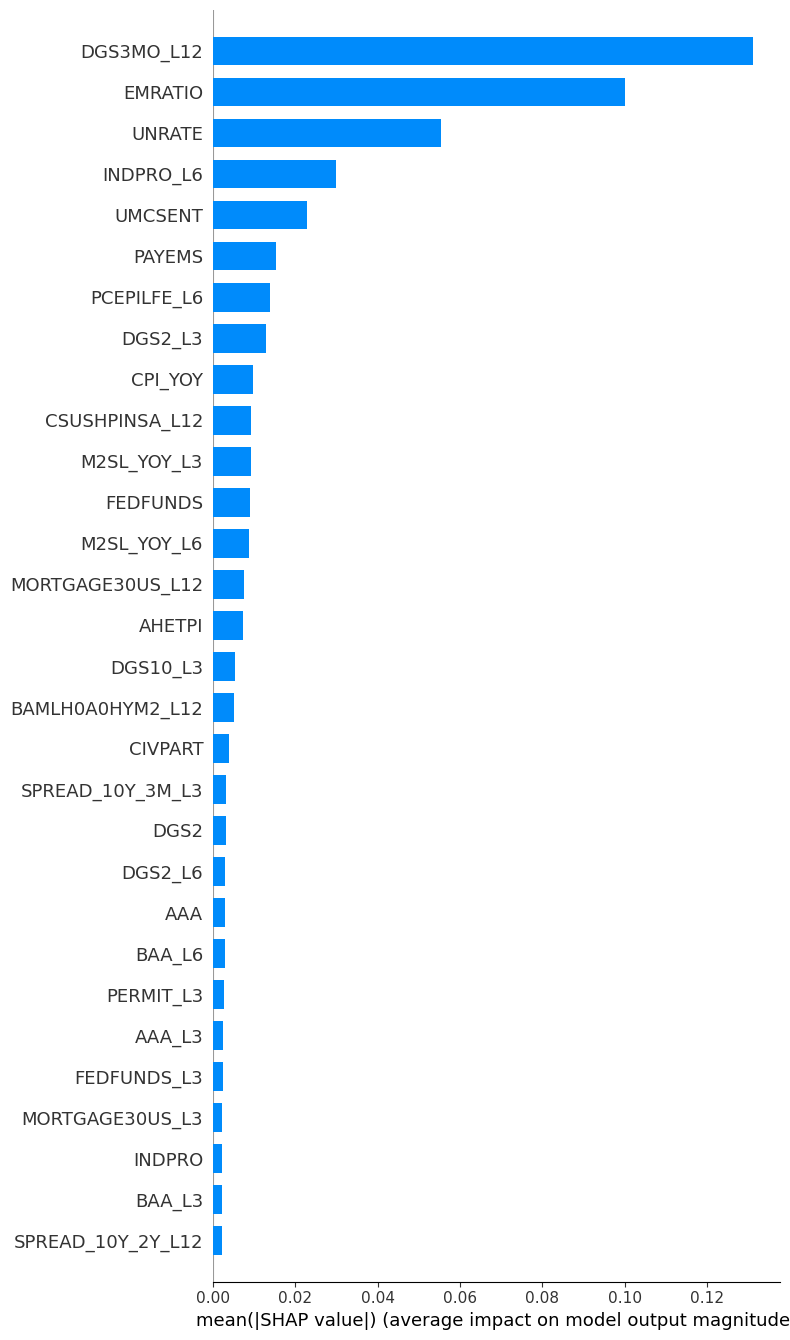

In [19]:
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=30)

In [20]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": X_val.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.head(30)

,feature,mean_abs_shap
97,DGS3MO_L12,0.131097
3,EMRATIO,0.100127
0,UNRATE,0.055379
72,INDPRO_L6,0.030001
14,UMCSENT,0.022767
1,PAYEMS,0.015314
69,PCEPILFE_L6,0.013753
98,DGS2_L3,0.013014
30,CPI_YOY,0.009642
91,CSUSHPINSA_L12,0.009165


In [21]:
TOP_K = 30
top_features = shap_importance.head(TOP_K)["feature"].tolist()

X_train_sel = X_train[top_features]
X_val_sel   = X_val[top_features]
X_test_sel  = X_test[top_features]

print("Reduced feature shapes:")
print("Train:", X_train_sel.shape)
print("Val  :", X_val_sel.shape)
print("Test :", X_test_sel.shape)

Reduced feature shapes:
Train: (6000, 30)
Val  : (1800, 30)
Test : (1800, 30)


In [22]:
# save train, val and test datasets

import os
import pandas as pd

OUT_DIR = "../artifacts/data_transformation"

print("Saving to:", os.path.abspath(OUT_DIR))

# Combine X + y
train_df = X_train_sel.copy()
train_df["target_nfci"] = y_train.values

val_df = X_val_sel.copy()
val_df["target_nfci"] = y_val.values

test_df = X_test_sel.copy()
test_df["target_nfci"] = y_test.values

# Save
train_df.to_csv(os.path.join(OUT_DIR, "train.csv"), index=False)
val_df.to_csv(os.path.join(OUT_DIR, "val.csv"), index=False)
test_df.to_csv(os.path.join(OUT_DIR, "test.csv"), index=False)

print("Saved files:")
print(" - train.csv:", train_df.shape)
print(" - val.csv  :", val_df.shape)
print(" - test.csv :", test_df.shape)

Saving to: /Users/swathi/Downloads/AAI-540-final-project/horizoncapital-forecaster-mlops/artifacts/data_transformation
Saved files:
 - train.csv: (6000, 31)
 - val.csv  : (1800, 31)
 - test.csv : (1800, 31)


In [23]:
# saving the feature engineered dataset under artifacts
OUT_DIR_INGESTION = "../artifacts/data_ingestion"
os.makedirs(OUT_DIR_INGESTION, exist_ok=True)

out_path = os.path.join(OUT_DIR_INGESTION, "feature_dataset_nfci_h12.csv")

df_model_clean.to_csv(out_path, index=False)

print("Saved df_model_clean to:")
print(os.path.abspath(out_path))
print("Shape:", df_model_clean.shape)

Saved df_model_clean to:
/Users/swathi/Downloads/AAI-540-final-project/horizoncapital-forecaster-mlops/artifacts/data_ingestion/feature_dataset_nfci_h12.csv
Shape: (9600, 156)
